In this notebook we create several truth datasets for testing the precision and recall of SIMBA from several existing publically available databases/studies. 

### Loading libraries

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

params = {'legend.fontsize': 'small',
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small',
         'figure.figsize': (3, 2)}
plt.rcParams.update(params)
  
import os
import glob
import re
import itertools
import collections
from collections import Counter
import math
import random
from random import randrange
import string
import subprocess

import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import seaborn as sns 
import phylopandas as ph

cmap = sns.cm.rocket_r
sns.set_style("white")

import anndata
from anndata import read_h5ad
from anndata import AnnData
import phylopandas as ph
import wget


### Directories

In [ ]:
mainDir = '/oak/stanford/groups/quake/gita/raw/nb/microbe/paper/forGitHub/post_review/'
mainDir1= mainDir + 'human_Gastrointestinal_Bacteria_Culture_Collection/'
mainDir2='/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/batch_of_ten/'
mainDir3 = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/refseq/'
mainDir4 = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/fungal/'
tosave = mainDir + 'files_to_upload_to_github'

dbDir = '/oak/stanford/groups/quake/gita/raw/database/'


### One batch of 500 random bacterial seqs from the human gut

first going to read a tsv file (filereport_read_run_PRJEB23845_tsv.txt downloaded from https://www.ebi.ac.uk/ena/browser/view/PRJEB23845?show=reads) containing the ftp addresses for genomes in the human gut microbiome isolates so I can download them and randomly select regions from various genomes to build a truth dataset for testing how well SIMBA can detect microbes. 

The associated paper:
https://www.nature.com/articles/s41587-018-0009-7#data-availability
Human Gastrointestinal Bacteria Culture Collection


In [3]:
cd $mainDir1

/oak/stanford/groups/quake/gita/raw/nb/microbe/paper/forGitHub/post_review/human_Gastrointestinal_Bacteria_Culture_Collection


In [4]:
addresses = pd.read_csv(mainDir + 'filereport_read_run_PRJEB23845_tsv.txt', delimiter='\t')

got the ftp addresses

In [4]:
mainDir = '/oak/stanford/groups/quake/gita/raw/nb/microbe/paper/forGitHub/post_review/'
mainDir1= mainDir + 'human_Gastrointestinal_Bacteria_Culture_Collection/'
mainDir2='/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/batch_of_ten/'
mainDir3 = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/refseq/'
mainDir4 = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/fungal/'
tosave = mainDir + 'files_to_upload_to_github'

dbDir = '/oak/stanford/groups/quake/gita/raw/database/'


In [5]:
addresses.head(3)

,study_accession,sample_accession,experiment_accession,run_accession,tax_id,scientific_name,fastq_ftp,submitted_ftp,sra_ftp
0,PRJEB23845,SAMEA3539430,ERX1276161,ERR1203919,47715,Lacticaseibacillus rhamnosus,ftp.sra.ebi.ac.uk/vol1/fastq/ERR120/009/ERR120...,ftp.sra.ebi.ac.uk/vol1/run/ERR120/ERR1203919/1...,NaN
1,PRJEB23845,SAMEA3539431,ERX1276162,ERR1203920,562,Escherichia coli,ftp.sra.ebi.ac.uk/vol1/fastq/ERR120/000/ERR120...,ftp.sra.ebi.ac.uk/vol1/run/ERR120/ERR1203920/1...,NaN
2,PRJEB23845,SAMEA3539432,ERX1276163,ERR1203921,1351,Enterococcus faecalis,ftp.sra.ebi.ac.uk/vol1/fastq/ERR120/001/ERR120...,ftp.sra.ebi.ac.uk/vol1/run/ERR120/ERR1203921/1...,NaN


Initially, I got the genomes from this study from the addresses dataframe (above) but after blasting sequences from those genomes, I would get a different species listed. I assume this is because taxnonomic annotation is different across nt (latest version) and this study. So, I am taking taxids from this study and retrieving corresponding genomes from NCBI. 

first getting unique taxids from this study

In [4]:
taxids_unique=list(addresses.tax_id.unique())

we can use the taxids to retrieve ftp paths for downloading genomes from this assembly report downloaded from NCBI (under 16): https://www.ncbi.nlm.nih.gov/genome/doc/ftpfaq/ 

In [104]:
wget.download('https://ftp.ncbi.nlm.nih.gov/genomes/refseq/bacteria/assembly_summary.txt')

'assembly_summary.txt'

now getting the files
first removed the comment line (first line from the file using the following command in the command line: sed -i '1d' assembly_summary.txt)

In [6]:
assembly_report=pd.read_csv(mainDir1 + 'assembly_summary.txt', delimiter='	')
header = ['assembly_accession', 'bioproject', 'biosample', 'wgs_master',
       'refseq_category', 'taxid', 'species_taxid', 'organism_name',
       'infraspecific_name', 'isolate', 'version_status', 'assembly_level',
       'release_type', 'genome_rep', 'seq_rel_date', 'asm_name', 'submitter',
       'gbrs_paired_asm', 'paired_asm_comp', 'ftp_path',
       'excluded_from_refseq', 'relation_to_type_material',
       'asm_not_live_date']
assembly_report.columns = header
assembly_report.head(3)

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid,species_taxid,organism_name,infraspecific_name,isolate,...,genome_rep,seq_rel_date,asm_name,submitter,gbrs_paired_asm,paired_asm_comp,ftp_path,excluded_from_refseq,relation_to_type_material,asm_not_live_date
0,GCF_900128725.1,PRJNA224116,SAMEA4556317,NaN,na,9,9,Buchnera aphidicola,strain=BCifornacula,2912,...,Full,2016/11/25,BCifornacula_v1.0,Centre de Biologie pour la Gestion des Populat...,GCA_900128725.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/9...,NaN,NaN,na
1,GCF_008244535.1,PRJNA224116,SAMN12634886,VTFL00000000.1,na,14,14,Dictyoglomus thermophilum,strain=PYS_80_B,NaN,...,Full,2019/09/02,ASM824453v1,Agharkar Research Institute,GCA_008244535.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,NaN,na
2,GCF_001735525.1,PRJNA224116,SAMN05384437,MCBT00000000.1,representative genome,23,23,Shewanella colwelliana,strain=CSB03KR,NaN,...,Full,2016/09/19,ASM173552v1,Chonnam National University,GCA_001735525.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,NaN,na


now getting the assembly report dataframe to only contain species from the gut study

In [145]:
assembly_report_fil = assembly_report[assembly_report['taxid'].isin(taxids_unique)]
assembly_report_fil.shape


(61782, 23)

taking only unique entries

In [146]:
assembly_report_fil2 = assembly_report_fil.drop_duplicates(subset=['taxid'])
#just renaming the dataframe for easier access
arf = assembly_report_fil2 

the ftp path doesn't take me to the genome. It takes me to a folder that contains the genome, so I appended the right address to be able to get the genome

In [50]:
arf['genome']= arf['ftp_path'].apply(lambda x: x.split('/')[-1] + '_genomic.fna.gz')
arf['genome_link'] = arf['ftp_path'] + '/' + arf['genome']
ftps = assembly_report_fil2['genome_link'].tolist()

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


downloading the genomes

In [202]:
for path in ftps:
    wget.download(path)

Now I want to get 10 random sequences, each 100 bases long, from 50 random bacterial genomes (selected from the gut) and collect them as part of one dataframe. Once I have the dataframe, I will use phylopandas to write a fasta file. This will become the test bacterial dataset. Will test it before adding viruses & fungi

In [372]:
#sampling x sequences from each genome
x=10 #number of sequences from a genome to obtain
seq_len=100 #length of the sequence to blast
num_genomes = 50


random_seq_df=pd.DataFrame({})
counter =0
for file in glob.glob(mainDir1 + '*.fna'):  
    df = ph.read_fasta(file)
    if counter<num_genomes:
        if df.shape[0]>=x: #if the genome file has at least 10 long seqs associated with it to choose random seqs from
            counter=counter+1 #want only to sample 50 genomes
            genome=file.split('/')[-1] + '.gz'
            sub_df = df.iloc[:x, :]
            sub_df['rand_seq'] = sub_df['sequence'].apply(lambda x: x[100:100+seq_len]) #start at 500bp for each contig and take 100 bases
            sub_df['genome']=genome
            random_seq_df=pd.concat([random_seq_df, sub_df])    
    else:
        break
    

#merging dataframes to get information about each random seq 
arf_sub=arf[['assembly_accession','bioproject','taxid','organism_name','infraspecific_name','ftp_path','genome']]
random_seq_df_sub=random_seq_df[['id','rand_seq','description','genome']]
blast_df=random_seq_df_sub.merge(arf_sub, on='genome')
blast_df.shape #should be 500 (50 genomes, 10 random segments each)

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(500, 11)

In [382]:
blast_df.head(3)

,id,rand_seq,description,genome,assembly_accession,bioproject,taxid,organism_name,infraspecific_name,ftp_path,genome_path
0,NZ_JAAITI010000095.1,TGACCTTGTTATCATCCTTGATTTCCAGTCCCGTGTAATCTGATTT...,NZ_JAAITI010000095.1 Blautia luti strain MSK.1...,GCF_013304735.1_ASM1330473v1_genomic.fna.gz,GCF_013304735.1,PRJNA224116,89014,Blautia luti,strain=MSK.16.34,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,GCF_013304735.1_ASM1330473v1_genomic.fna.gz
1,NZ_JAAITI010000096.1,AATTCAGTTATTTGAAAAATATTTTCCCAACATGAAACTTCCCGCT...,NZ_JAAITI010000096.1 Blautia luti strain MSK.1...,GCF_013304735.1_ASM1330473v1_genomic.fna.gz,GCF_013304735.1,PRJNA224116,89014,Blautia luti,strain=MSK.16.34,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,GCF_013304735.1_ASM1330473v1_genomic.fna.gz
2,NZ_JAAITI010000097.1,TCTCAAAGCAGTTTCAAAAGTTTGCGGATGAGGTGATTCCTTATCA...,NZ_JAAITI010000097.1 Blautia luti strain MSK.1...,GCF_013304735.1_ASM1330473v1_genomic.fna.gz,GCF_013304735.1,PRJNA224116,89014,Blautia luti,strain=MSK.16.34,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,GCF_013304735.1_ASM1330473v1_genomic.fna.gz


saving the resulting dataframe and then saving it in fasta form as well 

In [21]:
blast_df[['taxid', 'organism_name','infraspecific_name', 'genome', 'ftp_path', 'assembly_accession'
         ]].to_csv('/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/random_contigs_gut_bacterial_genomes_500_contigs.csv')

This will write a file called "random_contigs_gut_bacterial_genomes_500_contigs.fasta".  
The headers follow this format: **'taxon id'_'ncbi_contig_id'_'organism_name'**:

89014_NZ_JAAITI010000096.1_Blautia luti


In [384]:
# #Opening a fasta file to write random sequences to
f= open('random_contigs_gut_bacterial_genomes_500_contigs.fasta', 'w')
for i in list(range(0,blast_df.shape[0])):
    header = str(blast_df['taxid'].iat[i]) + '_'+ str(blast_df['id'].iat[i]) + '_' + blast_df['organism_name'].iat[i]
    sequence = blast_df['rand_seq'].iat[i]
    f.write('>' + header + '\n' + sequence + '\n')
f.close()


### 10 batches of 500 random bacterial seqs from the human gut (total 5000 seqs)
still from 50 random species (100 regions instead of 10). There is a possibility that 100 regions will enable higher precision/recall than 10 regions. 

In [12]:
!mkdir /oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/batch_of_ten

In [77]:
#sampling x sequences from each genome
x=10 #number of sequences from a genome to obtain
seq_len=100 #length of the sequence to blast
num_genomes = 50


random_seq_df=pd.DataFrame({})
counter =0
for file in glob.glob(mainDir1 + '*.fna'):  
    df = ph.read_fasta(file)
    if (counter<num_genomes): #if the genome file has at least x long seqs associated with it to choose random seqs from & #making sure the shortest contig is at least 6000 bases 
        if df.shape[0]>=x: 
            df['contig_length'] = df.sequence.apply(lambda x: len(x)) #getting the length of each contig 
            df = df.sort_values(by='contig_length', ascending=False) #sorting so that I select long contigs so that I can select multiple seqs from each contig
            if df['contig_length'].iat[x]> 6000:
                counter=counter+1 #want only to sample 50 genomes
                genome=file.split('/')[-1] + '.gz'
                sub_df = df.iloc[:x, :]            
        
            for i in range(100,5100, 400): #taking 10 random segments from a contig, starting at 100 base position
                sub_df['rand_seq'] = sub_df['sequence'].apply(lambda x: x[i:i+seq_len]) 
                sub_df['genome']=genome
                random_seq_df=pd.concat([random_seq_df, sub_df]) 
    else:
        break
    

#merging dataframes to get information about each random seq 
arf_sub=arf[['assembly_accession','bioproject','taxid','organism_name','infraspecific_name','ftp_path','genome']]
random_seq_df_sub=random_seq_df[['id','rand_seq','description','genome']]
blast_df=random_seq_df_sub.merge(arf_sub, on='genome')
blast_df.shape 

/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/gitam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6890, 10)

dropping any potential duplicates and sequences that have "N"

In [95]:
blast_df = blast_df.drop_duplicates()
blast_df = blast_df[~blast_df['rand_seq'].str.contains('N')]

selecting only 100 contigs per genome (currently there are about 130)

In [109]:
blast_df_100 = pd.DataFrame({})
for genome in blast_df.genome.unique():
    sub = blast_df[blast_df['genome']==genome].sample(n=100) 
    blast_df_100=pd.concat([blast_df_100, sub])

will create a unique id column (id2) otherwise segments from the same contig will have the same id in the resulting fasta file. 

In [115]:
id2=[str(x) for x in list(range(blast_df_100.shape[0]))]
blast_df_100['id2']=id2
blast_df_100['id2'] = blast_df_100['id'] + '_' + blast_df_100['id2']


spliting the main CSV file so I can run 10 SIMBA jobs in parallel. The following will produce both csvs and fasta files (500 sequences per file)

In [29]:
readsDir = mainDir2 + 'fasta_files/'


In [ ]:
!mkdir $readsDir

In [146]:
num_seq_per_batch=500 #how many seqs per fasta file
for i in range(0,blast_df_100.shape[0],num_seq_per_batch):
    start=i
    end=i+ num_seq_per_batch
    batch_df = blast_df_100.iloc[start:end]
    batch_df.to_csv(readsDir + 'batch_' + str(i) + '.csv')
    
    # #Opening a fasta file to write random sequences to
    f= open(readsDir + 'batch_' + str(i) + '.fasta', 'w')
    for i in list(range(0,batch_df.shape[0])):
        header = str(batch_df['taxid'].iat[i]) + '_'+ str(batch_df['id2'].iat[i]) + '_' + batch_df['organism_name'].iat[i]
        header = header.replace(' ', '_')
        sequence = batch_df['rand_seq'].iat[i] 
        f.write('>' + header + '\n' + sequence + '\n')
    f.close()



the above code works now, but there was an error at the level of fasta file writing wherer it was inputing the same sequence. I fixed it, and use the below block to write new files. The csvs were written correctly

In [34]:
num_seq_per_batch=500 #how many seqs per fasta file
for file in glob.glob('/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/batch_of_ten/fasta_files/*.csv'):
    batch_df = pd.read_csv(file)
    filename = file.split('/')[-1].split('.csv')[0]
    #Opening a fasta file to write random sequences to
    f= open(readsDir + filename + '.fasta', 'w')
    for i in list(range(0,batch_df.shape[0])):
        header = str(batch_df['taxid'].iat[i]) + '_'+ str(batch_df['id2'].iat[i]) + '_' + batch_df['organism_name'].iat[i]
        header = header.replace(' ', '_')
        sequence = batch_df['rand_seq'].iat[i]
        f.write('>' + header + '\n' + sequence + '\n')
    f.close()


### RefSeq bacterial truth dataset (100 seqs per genome, 10 batches for a total of 5000 seqs)
I want to see how SIMBA does in picking up bacteria in general, as opposed to bacterial species found in the gut. So here I will select 100 contigs per genome from 50 randomly selected Refseq bacterial species. 

no need to rerun this, as I already have refseq database saved as a dataframe. See databaseCreationSC_microbeDB_fungalDB_jan2021


In [139]:
refseq_dir = '/oak/stanford/groups/quake/gita/raw/tab2_20200508/tab2microbial/'


In [140]:
#Reading in the original fasta file, quickly converting it to dataframe
init=pd.DataFrame()
for file in glob.glob(dbDir + 'bactRepSeqs_Dec2020/ncbi-genomes-2020-12-16/*.fna'):
    df1 = ph.read_fasta(file)
    init = pd.concat([init, df1])

    
#extracting only genome names by replacing the genbank id
init['name']=init['description'].str.replace('N\w_\w+\d+.\d+ ', '')

#changing the names to contain only species information (don't want strains)
init['sp'] =init.name.str.split('strain')
init['sp'] = init['sp'].apply(lambda x: x[0])
init['sp2'] = init['sp'].apply(lambda x: x.split(' ')[0:2])
init['sp2'] = init['sp2'].apply(lambda x: ' '.join(x))

init.to_csv(refseq_dir + 'refSeqBacterial_Dec2020.csv')

reading the refseq database (from Dec 2020) and dropping duplicate species (i.e. different strains of the same species)


In [141]:
refseq =pd.read_csv(refseq_dir + 'refSeqBacterial_Dec2020.csv')
print('number of unique species in the refseq db:', refseq['sp2'].nunique())
print('total number of species in the refseq db:', len(refseq['sp2']))

refseq_unique=refseq.drop_duplicates(subset='name', keep='first')
print('number of unique species in refseq:', refseq_unique.shape)
refseq_unique.head(1)


number of unique species in the refseq db: 2683
total number of species in the refseq db: 4506
number of unique species in refseq: (4499, 9)


,Unnamed: 0,id,sequence,description,label,uid,name,sp,sp2
0,0,NZ_CP018632.1,GGATGATTTTGACTGTTTTGTTAAGTACTTTTTCATCTCTTTATAT...,NZ_CP018632.1 Granulosicoccus antarcticus IMCC...,NZ_CP018632.1,kXmjXcTUkR,Granulosicoccus antarcticus IMCC3135 chromosom...,Granulosicoccus antarcticus IMCC3135 chromosom...,Granulosicoccus antarcticus


first I want to randomly select 50 species. first I will select those species for which I can find taxon id by matching their names to NCBI's assembly dataframe.  

In [147]:
orgs_with_taxid=list(set(refseq_unique['sp2']).intersection(set(assembly_report['organism_name']))) #organism with taxid in the refseq
refseq_unique = refseq_unique[refseq_unique['sp2'].isin(orgs_with_taxid)] #filtering refseq to contain only those organisms 
refseq_unique['genome_length'] = refseq_unique['sequence'].apply(lambda x: len(x)) #getting genome length too
refseq_unique_fil=refseq_unique[refseq_unique['genome_length']> 1e5] #making sure the genome is long enough to select 100 random regions without the regions being too close to each other
ref50 = refseq_unique_fil.sample(n=50)[['id', 'sequence', 'name', 'sp2', 'genome_length']] #randomly selecting 50 species




selecting 100 segments per genome (50 genomes)

In [148]:

#selecting 100 segments per genome (50 genomes)
#sampling x sequences from each genome
x=100 #number of sequences from a genome to obtain
seq_len=100 #length of the sequence to blast
num_genomes = 50

ref50_randseqs=pd.DataFrame({})
randseqs =[]
counter = 0
for index in range(ref50.shape[0]):
    genome_length = ref50['genome_length'].iat[index]
    for i in list(range(seq_len,genome_length-seq_len, 1000))[:x]: #taking 100 random segments from a genome
        ref50_randseqs=pd.concat([ref50_randseqs, pd.DataFrame(ref50.iloc[index]).T])
        randseqs.append(ref50['sequence'].iat[index][i:i+seq_len])
        counter=counter + 1
    
ref50_randseqs['rand_seq']= randseqs

ref50_randseqs.shape





(5000, 6)

ensuring there are no duplicate sequences or ones containing "N"

In [149]:
ref50_randseqs = ref50_randseqs.drop_duplicates()
ref50_randseqs = ref50_randseqs[~ref50_randseqs['rand_seq'].str.contains('N')]
ref50_randseqs.shape

(4999, 6)

adding a unique id column (id2) since random sequences from the same genome currently have the same id. 

In [150]:
id2=[str(x) for x in list(range(ref50_randseqs.shape[0]))]
ref50_randseqs['id2']= id2
ref50_randseqs['id2'] = ref50_randseqs['id'] + '_' + ref50_randseqs['id2']
ref50_randseqs = ref50_randseqs.reset_index().drop(columns={'index'}) #reset index

In [151]:
ref50_randseqs.head(1)

,id,sequence,name,sp2,genome_length,rand_seq,id2
0,NZ_CP019240.1,ATGACGCAGGGATCCCCCCACCGAACAGACCCCCCGGAAGTCCAGG...,Rhodoferax antarcticus strain DSMZ24876 chromo...,Rhodoferax antarcticus,3916274,AACAGCAGTTTCAGACCTGGATCAAGCCGTTGACAGCCCAGGTGTC...,NZ_CP019240.1_0


adding taxids by getting them from ncbi assembly report

In [152]:
assembly_report_short = assembly_report[['taxid', 'organism_name','infraspecific_name', 'ftp_path']]
assembly_report_short = assembly_report_short.rename(columns={'organism_name':'sp2'})
a = ref50_randseqs['sp2'].unique().tolist()
b = assembly_report_short[assembly_report_short['sp2'].isin(a)].drop_duplicates('sp2')
ref50_randseqs_withtaxid = ref50_randseqs.merge(b, on='sp2', how='left')

in addition to taxids I want to add taxonomic lineages 

In [153]:
tax = pd.read_csv(dbDir + 'taxonomyNCBI20200125/ncbi_lineages_2021-01-26.csv')
#want to take only the following columns from the lineage dataframe tax 
tax_short=tax[['tax_id','superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']]
tax_short = tax_short.rename(columns={'tax_id':'taxid'})

ref50_lineage=ref50_randseqs_withtaxid.merge(tax_short, on='taxid', how='left')
ref50_lineage.head(1)

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,6,7,8,11,12,13,14,15,16,17,18,19,20,28,29,30,31,32,33,34,35,36,38,41,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,61,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,sequence,name,sp2,genome_length,rand_seq,id2,taxid,infraspecific_name,ftp_path,superkingdom,phylum,class,order,family,genus,species
0,NZ_CP019240.1,ATGACGCAGGGATCCCCCCACCGAACAGACCCCCCGGAAGTCCAGG...,Rhodoferax antarcticus strain DSMZ24876 chromo...,Rhodoferax antarcticus,3916274,AACAGCAGTTTCAGACCTGGATCAAGCCGTTGACAGCCCAGGTGTC...,NZ_CP019240.1_0,81479,strain=DSMZ24876,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Comamonadaceae,Rhodoferax,Rhodoferax antarcticus


now dividing this dataframe into 10 csvs and fasta files to run 10 SIMBA jobs in parallel

In [30]:
readsDir2 = mainDir3 + 'fasta_files/'


In [ ]:
!mkdir $readsDir2

In [154]:
num_seq_per_batch=500 #how many seqs per fasta file
for i in range(0,ref50_lineage.shape[0],num_seq_per_batch):
    start=i
    end=i+ num_seq_per_batch
    batch_df = ref50_lineage.iloc[start:end]
    batch_df.to_csv(readsDir2 + 'batch_' + str(i) + '.csv')
    
    #Opening a fasta file to write random sequences to
    f= open(readsDir2 + 'batch_' + str(i) + '.fasta', 'w')
    for i in list(range(0,batch_df.shape[0])):
        header = str(batch_df['taxid'].iat[i]) + '_'+ str(batch_df['id2'].iat[i]) + '_' + batch_df['sp2'].iat[i]
        header = header.replace(' ', '_')
        sequence = batch_df['rand_seq'].iat[i]
        f.write('>' + header + '\n' + sequence + '\n')
    f.close()


### Human only dataset 
I want to see what are the rates of false positives and negatives when we only have 2400 sequences randomly selected from the human genome (100 seqs per chromosomes 1-22 and X, Y). I have the human genome assembly from GCF_000001405.39_GRCh38.p13_genomic.fna 

In [44]:
humanGenome = dbDir + 'human_genome_and_synthetic_chromosomes_july2021/GCF_000001405.39_GRCh38.p13_genomic.fna'

reading the human genome fasta file as a csv since it's easier to select from it when its a datafame

In [46]:
hum=ph.read_fasta(humanGenome)

In [100]:
hum.head(3)

,id,sequence,description,label,uid
0,NC_000001.11,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,"NC_000001.11 Homo sapiens chromosome 1, GRCh38...",NC_000001.11,8L3DoCtTNR
1,NT_187361.1,GAATTCAGCTGAGAAGAACAGGCAAGGACTTAGGAAATATTCCTTA...,NT_187361.1 Homo sapiens chromosome 1 unlocali...,NT_187361.1,1wuQFgXyk8
2,NT_187362.1,AGGGGTCTGCTTAGAGAGGGTCTCATTAGTGGGGTCTAGTAGTGGG...,NT_187362.1 Homo sapiens chromosome 1 unlocali...,NT_187362.1,HET4WFJWNF


In [132]:
seq_len=100
x=100 #how many sequences per chromosome to take 
hum_randseqs=pd.DataFrame({})
randseqs =[]
chromosomes=[str(x+1) for x in list(range(22))]
chromosomes.append('X')
chromosomes.append('Y')

for i in chromosomes: 
    sub = hum[hum['description'].str.contains('Homo sapiens chromosome ' + i) ].iloc[1,:] #taking one of the segments from each chromosome to randomly select 100 sequences from
    sub['chromosome']= i
    segment_length = len(sub['sequence'])
    for j in list(range(seq_len+1000, segment_length-seq_len, 300))[:x]: #taking 100 random segments from each chromosome
        hum_randseqs=pd.concat([hum_randseqs, pd.DataFrame(sub).T])
        randseqs.append(sub['sequence'][j:j+seq_len])

hum_randseqs['rand_seq']= randseqs

id2=[str(x) for x in list(range(hum_randseqs.shape[0]))]
hum_randseqs['id2']=id2
hum_randseqs['id2'] = hum_randseqs['chromosome'] + '_' + hum_randseqs['id'] + '_' + hum_randseqs['id2']
hum_randseqs = hum_randseqs.reset_index().drop(columns={'index'}) #reset index


In [133]:
hum_randseqs.head(2)

,id,sequence,description,label,uid,chromosome,rand_seq,id2
0,NT_187361.1,GAATTCAGCTGAGAAGAACAGGCAAGGACTTAGGAAATATTCCTTA...,NT_187361.1 Homo sapiens chromosome 1 unlocali...,NT_187361.1,1wuQFgXyk8,1,GTAGATGTATCTTATCTTAACTTGAGTCTTTGCTGCCCCTAATGAG...,1_NT_187361.1_0
1,NT_187361.1,GAATTCAGCTGAGAAGAACAGGCAAGGACTTAGGAAATATTCCTTA...,NT_187361.1 Homo sapiens chromosome 1 unlocali...,NT_187361.1,1wuQFgXyk8,1,TTCTGAGTTTATGGGTGTCtgtgaattaaaaaggaaaagtagaaat...,1_NT_187361.1_1


In [125]:
hum_randseqs.chromosome.value_counts()

5     100
13    100
4     100
1     100
7     100
2     100
22    100
10    100
17    100
X     100
11    100
Y     100
15    100
12    100
8     100
18    100
3     100
14    100
21    100
6     100
9     100
16    100
20    100
19    100
Name: chromosome, dtype: int64

making sure there are not any sequences with "N"

In [155]:
hum_randseqs[~hum_randseqs['rand_seq'].str.contains('N')].shape[0]

2400

Let's add some unique IDs before saving in batches (for parallel jobs) both as csv and fasta file 

In [129]:
!mkdir /oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/human_test/fasta_files

mkdir: cannot create directory '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/human_test/fasta_files': File exists


also saving the data in batches (for parallel jobs) and saving it to csv & fasta

In [157]:
humdir = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/human_test/fasta_files/'
num_seq_per_batch=500 #how many seqs per fasta file
for i in range(0,hum_randseqs.shape[0], num_seq_per_batch):
    start=i
    end=i+ num_seq_per_batch
    batch_df = hum_randseqs.iloc[start:end]
    batch_df.to_csv(humdir + 'batch_' + str(i) + '.csv')

    # Opening a fasta file to write batch to 
    f= open(humdir + 'batch_' + str(i) + '.fasta', 'w')
    for j in list(range(0,batch_df.shape[0])):
        header = batch_df['id2'].iat[j] 
        sequence = batch_df['rand_seq'].iat[j]
        f.write('>' + header + '\n' + sequence + '\n')
    f.close()


### Viral (1000 total sequences, 100 genomes, 10 contigs per genome)
Getting test viral sequences
Since I already have a fasta file corresponding to the viral refseq database, I will subsample it. Downloaded March, 2020

In [207]:
virus_df=ph.read_fasta('/oak/stanford/groups/quake/gita/raw/database/viral_nr_march25_2020/viral_refseq_nuc/all_refseq_viral_genomes.fasta')

In [208]:
virus_df.head(2)

,id,sequence,description,label,uid
0,NC_001798.2,AGTCCCCGTCTTGCCGCGCGGGGGCGGGCGCGGGAAAAAAGCCGCG...,"NC_001798.2 Human herpesvirus 2 strain HG52, c...",NC_001798.2,YQipx4geNu
1,NC_030692.1,TGTTGCGTTAACAACAAATCAATCACCACTCTTCTAACAAAATGAA...,"NC_030692.1 Borna disease virus 2, complete ge...",NC_030692.1,7nZKEPSzP6


In [209]:
virus_df.id.nunique()

12182

randomly sampling 100 viruses, and taking 10 random segments (100 bases long) from each genome.

In [210]:
virus_df['genome_length']= virus_df['sequence'].apply(lambda x: len(x))
virus_df_100 = virus_df[virus_df['genome_length']>5000].sample(100) #making sure genomes are long enough to be selected for this exercise

seq_len=100
x=10 #how many sequences per genome to take 
vir_randseqs=pd.DataFrame({})
randseqs =[]

for i in range(virus_df_100.shape[0]): 
    sub = virus_df_100.iloc[i]
    genome_length = sub['genome_length']
    for j in list(range(seq_len+300, genome_length-seq_len, 300))[:x]: #taking 10 random segments from each genome
        vir_randseqs=pd.concat([vir_randseqs, pd.DataFrame(sub).T])
        randseqs.append(sub['sequence'][j:j+seq_len])

vir_randseqs['rand_seq']= randseqs

id2=[str(x) for x in list(range(vir_randseqs.shape[0]))]
vir_randseqs['id2']=id2
vir_randseqs['id2'] =  vir_randseqs['id'] + '_' + vir_randseqs['id2']
vir_randseqs['description'] = vir_randseqs['description'].apply(lambda x: x.replace(' ', '_'))
vir_randseqs = vir_randseqs.reset_index().drop(columns={'index'}) #reset index


writing fasta and csv files from the dataframe to input into SIMBA for testing (10 jobs, 100 seqs each)

In [218]:
virdir = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/viral_test/fasta_files/'
num_seq_per_batch=100 #how many seqs per fasta file
for i in range(0,vir_randseqs.shape[0], num_seq_per_batch):
    start=i
    end=i+ num_seq_per_batch
    batch_df = vir_randseqs.iloc[start:end]
    batch_df.to_csv(virdir + 'batch_' + str(i) + '.csv')

    # Opening a fasta file to write batch to 
    f= open(virdir + 'batch_' + str(i) + '.fasta', 'w')
    for j in list(range(0,batch_df.shape[0])):
        header = batch_df['id2'].iat[j] + '_' + batch_df['description'].iat[j]
        sequence = batch_df['rand_seq'].iat[j]
        f.write('>' + header + '\n' + sequence + '\n')
    f.close()


### eHOMD (expanded Human Oral Microbiome Dataset)
Besides the bacterial refseq and the gut bacterial truth datasets, I want to create one that has bacteria from differrent parts of the body, namely several sites from the oral microbiome. First I downloaded a manifest file from HOMD, which I downloaded to OAK using the followinig command from my local computer 
rsync ~/Downloads/HOMD_taxon_table2022-09-15_1663245201.txt  sherlock://oak/stanford/groups/quake/gita/raw/nb/microbe/paper/forGitHub/post_review/homd/.

I also got other info related to each species from a seperate file: HOMD_genome_table2022-09-15_1663245202.txt

Both files were downloaded from: https://www.homd.org/download#genome

In [109]:
homd_dir = '/oak/stanford/groups/quake/gita/raw/nb/microbe/paper/forGitHub/post_review/homd/'
homd_file = 'HOMD_taxon_table2022-09-15_1663245201.txt'
homd=pd.read_csv(homd_dir + homd_file, delimiter='	')
homd.columns = [x.lower() for x in homd.columns.tolist()] #making sure the column headers are lower case for easier typing
homd.head()

,hmt_id,domain,phylum,class,order,family,genus,species,status,body_site,...,ncbi_pubmed_count,ncbi_nucleotide_count,ncbi_protein_count,genome_id,general_info,cultivability,phenotypic_characteristics,prevalence,disease,references
0,1,Bacteria,Proteobacteria,Alphaproteobacteria,Hyphomicrobiales,Bartonellaceae,Bartonella,schoenbuchensis,Named,Unassigned,...,9,93,5894,SEQF2664,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Caulobacter,sp._HMT_002,Phylotype,Unassigned,...,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,glacialis,Named,Unassigned,...,0,2,0,SEQF3079,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,sp._HMT_004,Phylotype,Unassigned,...,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,lwoffii,Named,Unassigned,...,0,0,0,SEQF2884,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
homd.columns

Index(['hmt_id', 'domain', 'phylum', 'class', 'order', 'family', 'genus',
       'species', 'status', 'body_site', 'warning', 'type_strain', '16s_rrna',
       'clone_count', 'clone_%', 'clone_rank', 'synonyms', 'ncbi_taxon_id',
       'ncbi_pubmed_count', 'ncbi_nucleotide_count', 'ncbi_protein_count',
       'genome_id', 'general_info', 'cultivability',
       'phenotypic_characteristics', 'prevalence', 'disease', 'references'],
      dtype='object')

reading the meta file and selecting 200 genomes ...

In [153]:
homd_sub=homd[homd['body_site']=='Oral']

homd_sub2 = homd_sub.sample(n=200)
homd_sub3 = homd_sub2.drop_duplicates(['ncbi_taxon_id'])

In [154]:
homd_sub3['ncbi_taxon_id'].nunique()

180

In [155]:
taxa = homd_sub3['ncbi_taxon_id'].unique().tolist()

saving homd_sub3 because it is a random selection and I don't want to have it changeding the file

In [157]:
homd_sub3.to_csv(homd_dir + 'homd_200_genomes_randomly_selected.csv')

In [132]:
meta_file = homd_dir + 'HOMD_genome_table2022-09-15_1663245202.txt'
meta = pd.read_csv(meta_file, delimiter='	')
meta.columns

Index(['Genome-ID', 'Oral_Taxon-ID', 'Genus', 'Species', 'Status',
       'No. Contigs', 'Sequencing Center', 'Total Length', 'Oral Pathogen',
       'Culture Collection', 'GC %', 'NCBI Genome-ID', 'NCBI BioProject-ID',
       'NCBI BioSample-ID', 'Isolate Origin', 'atcc_mn', 'non_atcc_mn',
       'Genbank Acc no.', 'Genbank Assembly', '16S rRNA', '16S rRNA Comment',
       'flag_id'],
      dtype='object')

reading NCBI's assembly report to be able to download the genomes in the homd data based on their Genbank assmebly numbers

In [135]:
assembly_report=pd.read_csv(mainDir1 + 'assembly_summary.txt', delimiter='	')
header = ['assembly_accession', 'bioproject', 'biosample', 'wgs_master',
       'refseq_category', 'taxid', 'species_taxid', 'organism_name',
       'infraspecific_name', 'isolate', 'version_status', 'assembly_level',
       'release_type', 'genome_rep', 'seq_rel_date', 'asm_name', 'submitter',
       'gbrs_paired_asm', 'paired_asm_comp', 'ftp_path',
       'excluded_from_refseq', 'relation_to_type_material',
       'asm_not_live_date']
assembly_report.columns = header
assembly_report.head(3)

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid,species_taxid,organism_name,infraspecific_name,isolate,...,genome_rep,seq_rel_date,asm_name,submitter,gbrs_paired_asm,paired_asm_comp,ftp_path,excluded_from_refseq,relation_to_type_material,asm_not_live_date
0,GCF_900128725.1,PRJNA224116,SAMEA4556317,NaN,na,9,9,Buchnera aphidicola,strain=BCifornacula,2912,...,Full,2016/11/25,BCifornacula_v1.0,Centre de Biologie pour la Gestion des Populat...,GCA_900128725.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/9...,NaN,NaN,na
1,GCF_008244535.1,PRJNA224116,SAMN12634886,VTFL00000000.1,na,14,14,Dictyoglomus thermophilum,strain=PYS_80_B,NaN,...,Full,2019/09/02,ASM824453v1,Agharkar Research Institute,GCA_008244535.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,NaN,na
2,GCF_001735525.1,PRJNA224116,SAMN05384437,MCBT00000000.1,representative genome,23,23,Shewanella colwelliana,strain=CSB03KR,NaN,...,Full,2016/09/19,ASM173552v1,Chonnam National University,GCA_001735525.1,identical,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,NaN,NaN,na


In [158]:
assembly_report_fil = assembly_report[assembly_report['taxid'].isin(taxa)]
assembly_report_fil.shape


(3327, 23)

I only need 50 genomes, so I will drop any duplicate taxids and take the first 50

In [160]:
arf2 =assembly_report_fil.drop_duplicates(['taxid'])[:50]

downloading the genomes

In [164]:
download_dir = homd_dir + 'genomes_from_homd_50'
!cd $download_dir

as before the ftp_path doesn't take me to the genome, so need to get the genomic path

In [176]:
arf2['genome']= arf2['ftp_path'].apply(lambda x: x.split('/')[-1] + '_genomic.fna.gz')
arf2['genome_link'] = arf2['ftp_path'] + '/' + arf2['genome']
ftps = arf2['genome_link'].tolist()

I got these files by creating a list in the terminal and running the following in the terminal

In [ ]:
lst=('path1 path2 ... pathn')
for f in $lst; do  wget $f; done

putting together genomic fasta files that were downloaded into dataframe format for easier processing and sampling. 

In [203]:
homd_reads =pd.DataFrame({})
for file in glob.glob(homd_dir + 'genomes_from_homd_50/*.fna'):
    df = ph.read_fasta(file)
    df['filename']= file.split('/')[-1].split('_genomic.fna')[0]
    df=df[['id', 'sequence', 'description', 'filename']]
    homd_reads = pd.concat([homd_reads, df])


In [233]:
homd_reads.head(1)

,id,sequence,description,filename,seq_length
0,NZ_CP028108.1,TCATTCTTTTGTTTCTCCTTCTTTTCCTTCTTTTCCTTCTTCAAGT...,NZ_CP028108.1 Fusobacterium periodonticum stra...,GCF_003019755.1_ASM301975v1,2541084


now I will do everything I did for getting gut bacterial sequences (5000 seqs) to be processed as batch of 10 fasta files for being input to SIMBA

In [235]:
#sampling x sequences from each genome
x=100 #number of sequences from a genome to obtain
seq_len=100 #length of the sequence to blast
num_genomes = 50

homd_reads['genome_length'] = homd_reads['sequence'].apply(lambda x: len(x))
ref50=homd_reads[homd_reads['genome_length']>=50000] #taking only genomic segments that are 50k long 
ref50 = ref50.groupby('filename').apply(lambda x: x.sample(1)).reset_index(drop=True) 

ref50_randseqs=pd.DataFrame({})
randseqs =[]
counter = 0
for index in range(ref50.shape[0]):
    genome_length = ref50['genome_length'].iat[index]
    for i in list(range(seq_len,genome_length-seq_len, 500))[:x]: #taking 100 random segments from a genome
        ref50_randseqs=pd.concat([ref50_randseqs, pd.DataFrame(ref50.iloc[index]).T])
        randseqs.append(ref50['sequence'].iat[index][i:i+seq_len])
        counter=counter + 1
    
ref50_randseqs['rand_seq']= randseqs

print(ref50_randseqs.shape[0])

# ensuring there are no duplicate sequences or ones containing "N"
ref50_randseqs = ref50_randseqs.drop_duplicates()
ref50_randseqs = ref50_randseqs[~ref50_randseqs['rand_seq'].str.contains('N')]
print(ref50_randseqs.shape[0])

# adding a unique id column (id2) since random sequences from the same genome currently have the same id. 
id2=[str(x) for x in list(range(ref50_randseqs.shape[0]))]
ref50_randseqs['id2']= id2
ref50_randseqs['id2'] = ref50_randseqs['id'] + '_' + ref50_randseqs['id2']
ref50_randseqs = ref50_randseqs.reset_index().drop(columns={'index'}) #reset index


5000
4997


In [242]:
ref50_randseqs.head(1)

,id,sequence,description,filename,seq_length,genome_length,rand_seq,id2
0,NC_014334.2,ATGCCCAATTTAGAGGAACTTTGGGCTTACCTGAATGATAAATTCC...,"NC_014334.2 Lacticaseibacillus paracasei, comp...",GCF_000019245.4_ASM1924v3,2861969,2861969,TCAAATTAACCAAAGATAAACTCGAAATTGAAGTCCCAGCTTCTTT...,NC_014334.2_0


In [263]:
#adding taxids by getting them from ncbi assembly report
arf3 = arf2[['taxid', 'organism_name','infraspecific_name', 'ftp_path', 'assembly_accession']]
ref50_randseqs['assembly_accession'] = ref50_randseqs['filename'].apply(lambda x: '_'.join(x.split('_')[0:2]))
ref50_randseqs_withtaxid = arf3.merge(ref50_randseqs, on='assembly_accession', how='right')

#in addition to taxids I want to add taxonomic lineages 
tax = pd.read_csv(dbDir + 'taxonomyNCBI20200125/ncbi_lineages_2021-01-26.csv')
#want to take only the following columns from the lineage dataframe tax 
tax_short=tax[['tax_id','superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']]
tax_short = tax_short.rename(columns={'tax_id':'taxid'})

ref50_lineage=ref50_randseqs_withtaxid.merge(tax_short, on='taxid', how='left')
ref50_lineage['sp2']=ref50_lineage['species'].apply(lambda x: "_".join(x.split(' ')).lower())
ref50_lineage.head(1)


/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,6,7,8,11,12,13,14,15,16,17,18,19,20,28,29,30,31,32,33,34,35,36,38,41,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,61,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,taxid,organism_name,infraspecific_name,ftp_path,assembly_accession,id,sequence,description,filename,seq_length,genome_length,rand_seq,id2,superkingdom,phylum,class,order,family,genus,species
0,158,Treponema denticola,strain=OMZ 853,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/0...,GCF_024181405.1,NZ_CP051302.1,ATGAGTGAATGGGATTATAAAATTTTTTGGGATGAAGCTGTTAAGC...,NZ_CP051302.1 Treponema denticola strain OMZ 8...,GCF_024181405.1_ASM2418140v1,2749579,2749579,AATATGAAAAATCTACGGAAAATACCGTATATCTTAGTGTTCCGTC...,NZ_CP051302.1_4497,Bacteria,Spirochaetes,Spirochaetia,Spirochaetales,Spirochaetaceae,Treponema,Treponema denticola


In [276]:
#now diving this dataframe into 10 csvs and fasta files to run 10 SIMBA jobs in parallel
readsDir2 = '/oak/stanford/groups/quake/gita/raw/tab3-14_20210420/benchmarking_post_reviews/bacterial_test/homd/fasta_files/'

num_seq_per_batch=500 #how many seqs per fasta file
for i in range(0,ref50_lineage.shape[0],num_seq_per_batch):
    start=i
    end=i+ num_seq_per_batch
    batch_df = ref50_lineage.iloc[start:end]
    batch_df.to_csv(readsDir2 + 'batch_' + str(i) + '.csv')
    
    #Opening a fasta file to write random sequences to
    f= open(readsDir2 + 'batch_' + str(i) + '.fasta', 'w')
    for i in list(range(0,batch_df.shape[0])):
        header = str(batch_df['taxid'].iat[i]) + '_'+ str(batch_df['id2'].iat[i]) + '_' + batch_df['sp2'].iat[i]
        header = header.replace(' ', '_')
        sequence = batch_df['rand_seq'].iat[i]
        f.write('>' + header + '\n' + sequence + '\n')
    f.close()

### Creating a fungal dataset

first downloading the NCBI genome assembly report for eukaryotes. After downloadinig NCBI's "dataset" package I was able to download the genomes using a list of assembly accession numbers. Here's the command I ran in the terminal (after activating the mainEnv2 environment). There is also a python api, but it was not working for me. Might try again later. see documentation here https://www.ncbi.nlm.nih.gov/datasets/docs/v1/download-and-install/

note list of accessions came from a study of fungi. https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-017-0373-4#Sec20


getting the fungi assembly accessions from this document from ncbi. Will capture the genomes that it shares in common with the study linked above

In [26]:
wget.download('https://ftp.ncbi.nlm.nih.gov/genomes/GENOME_REPORTS/eukaryotes.txt')

'eukaryotes.txt'

moving it to the fungal directory

In [28]:
mv $mainDir/eukaryotes.txt $mainDir4

In [69]:
euks_assembly = pd.read_csv(mainDir4 + 'eukaryotes.txt', delimiter='\t')
euks_assembly = euks_assembly.rename(columns={'Organism/Name':'organism','TaxID':'taxid'})

In [39]:
euks_assembly.head(1)

,organism,taxid,BioProject Accession,BioProject ID,Group,SubGroup,Size (Mb),GC%,Assembly Accession,Replicons,WGS,Scaffolds,Genes,Proteins,Release Date,Modify Date,Status,Center,BioSample Accession
0,Neopyropia yezoensis,2788,PRJNA589917,589917,Other,Other,107.591,64.8454,GCA_009829735.1,chromosome 1:CM020618.1; chromosome 2:CM020619...,WMLA01,28.0,-,-,2020/01/03,2020/01/06,Chromosome,Ocean University,SAMN13316713


found a list of fungal species in the gut

In [90]:
fung=pd.read_excel(mainDir4 + '40168_2017_373_MOESM3_ESM.xlsx').sort_values(by='Reads (n=27,091,491,028)', ascending=False).iloc[1:100]
fung_as=euks_assembly[euks_assembly['organism'].isin(fung['Name'].tolist())].drop_duplicates('organism')[:50]
fung_as.head(1)

,organism,taxid,BioProject Accession,BioProject ID,Group,SubGroup,Size (Mb),GC%,Assembly Accession,Replicons,WGS,Scaffolds,Genes,Proteins,Release Date,Modify Date,Status,Center,BioSample Accession
11,Schizosaccharomyces pombe,4896,PRJNA13836,13836,Fungi,Ascomycetes,12.5913,36.0381,GCA_000002945.2,chromosome I:NC_003424.3/CU329670.1; chromosom...,-,4.0,6974,5131,2002/02/28,2022/07/14,Chromosome,S. pombe European Sequencing Consortium (EUPOM),SAMEA3138176


as before loading the data as a dataframe for easier processing

In [93]:
fung_reads =pd.DataFrame({})
for file in glob.glob(mainDir4 + 'genomes/*.fna'):
    df = ph.read_fasta(file)
    df['filename']= file.split('/')[-1].split('_genomic.fna')[0]
    df=df[['id', 'sequence', 'description', 'filename']]
    fung_reads = pd.concat([fung_reads, df])

fung_reads['Assembly Accession'] = fung_reads['filename'].apply(lambda x: '_'.join(x.split('_')[:-1]))

now I will do everything I did for getting gut bacterial sequences (5000 seqs) to be processed as batch of 10 fasta files for being input to SIMBA

In [108]:
#sampling x sequences from each genome
x=100 #number of sequences from a genome to obtain
seq_len=100 #length of the sequence to blast
num_genomes = 50

fung_reads['genome_length'] = fung_reads['sequence'].apply(lambda x: len(x))
ref50=fung_reads[fung_reads['genome_length']>=50000] #taking only genomic segments that are 50k long 
ref50 = ref50.groupby('filename').apply(lambda x: x.sample(1)).reset_index(drop=True) 

ref50_randseqs=pd.DataFrame({})
randseqs =[]
counter = 0
for index in range(ref50.shape[0]):
    genome_length = ref50['genome_length'].iat[index]
    for i in list(range(seq_len,genome_length-seq_len, 500))[:x]: #taking 100 random segments from a genome
        ref50_randseqs=pd.concat([ref50_randseqs, pd.DataFrame(ref50.iloc[index]).T])
        randseqs.append(ref50['sequence'].iat[index][i:i+seq_len])
        counter=counter + 1
    
ref50_randseqs['rand_seq']= randseqs

print(ref50_randseqs.shape[0])

# ensuring there are no duplicate sequences or ones containing "N"
ref50_randseqs = ref50_randseqs.drop_duplicates()
ref50_randseqs = ref50_randseqs[~ref50_randseqs['rand_seq'].str.contains('N')]
print(ref50_randseqs.shape[0])

# adding a unique id column (id2) since random sequences from the same genome currently have the same id. 
id2=[str(x) for x in list(range(ref50_randseqs.shape[0]))]
ref50_randseqs['id2']= id2
ref50_randseqs['id2'] = ref50_randseqs['id'] + '_' + ref50_randseqs['id2']
ref50_randseqs = ref50_randseqs.reset_index().drop(columns={'index'}) #reset index


4500
4466


In [111]:
ref50_randseqs['Assembly Accession'].nunique()

45

In [118]:
tax = pd.read_csv(dbDir + 'taxonomyNCBI20200125/ncbi_lineages_2021-01-26.csv')
#want to take only the following columns from the lineage dataframe tax 
tax_short=tax[['tax_id','superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']]
tax_short = tax_short.rename(columns={'tax_id':'taxid'})

ref50_lineage = ref50_randseqs.merge(tax_short, on='taxid', how='left')

/home/users/gitam/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5,6,7,8,11,12,13,14,15,16,17,18,19,20,28,29,30,31,32,33,34,35,36,38,41,42,43,44,45,46,47,48,49,50,51,52,53,55,56,57,58,59,61,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
ref50_lineage.head(1)

,id,sequence,description,filename,Assembly Accession,organism,taxid,BioProject Accession,BioProject ID,Group,...,genome_length,rand_seq,id2,superkingdom,phylum,class,order,family,genus,species
0,CR382122.1,ccgtacaccacatacctaatcaaatccgtacaccacatacctaatc...,CR382122.1 Kluyveromyces lactis strain NRRL Y-...,GCA_000002515.1_ASM251v1,GCA_000002515.1,Kluyveromyces lactis,28985,PRJNA13835,13835,Fungi,...,1320834,ccgtacaccacatacctaatcaaatccgtacaccacatacctaatc...,CR382122.1_0,Eukaryota,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Kluyveromyces,Kluyveromyces lactis


now diving this dataframe into 10 csvs and fasta files to run 10 SIMBA jobs in parallel


In [121]:
num_seq_per_batch=500 #how many seqs per fasta file
for i in range(0,ref50_lineage.shape[0],num_seq_per_batch):
    start=i
    end=i+ num_seq_per_batch
    batch_df = ref50_lineage.iloc[start:end]
    batch_df.to_csv(mainDir4 + 'fasta_files/batch_' + str(i) + '.csv')
    
    #Opening a fasta file to write random sequences to
    f= open(mainDir4 + 'fasta_files/batch_' + str(i) + '.fasta', 'w')
    for i in list(range(0,batch_df.shape[0])):
        header = str(batch_df['taxid'].iat[i]) + '_'+ str(batch_df['id2'].iat[i]) + '_' + batch_df['species'].iat[i]
        header = header.replace(' ', '_')
        sequence = batch_df['rand_seq'].iat[i]
        f.write('>' + header + '\n' + sequence + '\n')
    f.close()

### Downloading Unified Human Gastrointestinal Genome 
http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/

In [8]:
wget.download('http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v2.0/genomes-all_metadata.tsv')

'genomes-all_metadata.tsv'

In [13]:
ug=pd.read_csv('genomes-all_metadata.tsv', delimiter='\t')
ug.head(1)

,Genome,Genome_type,Length,N_contigs,N50,GC_content,Completeness,Contamination,rRNA_5S,rRNA_16S,rRNA_23S,tRNAs,Genome_accession,Species_rep,Lineage,Sample_accession,Study_accession,Country,Continent,FTP_download
0,MGYG000000001,Isolate,3219617,137,47258,28.26,98.59,0.7,88.24,99.74,99.83,20,GUT_GENOME000001,MGYG000000001,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,ERS370061,ERP105624,United Kingdom,Europe,ftp://ftp.ebi.ac.uk/pub/databases/metagenomics...


<AxesSubplot:ylabel='Frequency'>

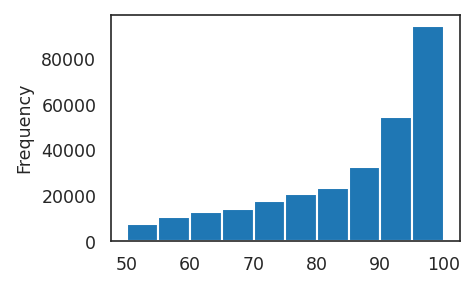

In [49]:
ug['Completeness'].plot(kind='hist')

In [72]:
ug['domain'] = ug['Lineage'].apply(lambda x: x.split('d__')[1].split(';p__')[0])
ug['phylum'] =ug['Lineage'].apply(lambda x: x.split('d__')[1].split(';p__')[1].split(';c__')[0].split('_')[0])
ug['class'] =ug['Lineage'].apply(lambda x: x.split('d__')[1].split(';p__')[1].split(';c__')[1].split(';o__')[0])
ug['order'] =ug['Lineage'].apply(lambda x: x.split('d__')[1].split(';p__')[1].split(';c__')[1].split(';o__')[1].split(';f__')[0])
ug['family'] =ug['Lineage'].apply(lambda x: x.split('d__')[1].split(';p__')[1].split(';c__')[1].split(';o__')[1].split(';f__')[1].split(';g__')[0])
ug['genus'] =ug['Lineage'].apply(lambda x: x.split('d__')[1].split(';p__')[1].split(';c__')[1].split(';o__')[1].split(';f__')[1].split(';g__')[1].split(';s__')[0].split('_')[0])
ug['species'] =ug['Lineage'].apply(lambda x: x.split('d__')[1].split(';p__')[1].split(';c__')[1].split(';o__')[1].split(';f__')[1].split(';g__')[1].split(';s__')[1].replace('_A',''))


In [77]:
ug.genus.value_counts().head(60)

Bacteroides              13756
Ruminococcus             12981
Alistipes                10967
Agathobacter             10651
Phocaeicola               9033
Prevotella                8886
Bifidobacterium           8703
Faecalibacterium          8598
Escherichia               8359
Lachnospira               7900
Parabacteroides           6923
Gemmiger                  6124
Eubacterium               5112
Blautia                   4858
Phascolarctobacterium     4610
Collinsella               4169
CAG-83                    4042
Acetatifactor             3497
Coprococcus               3338
Akkermansia               3311
Fusicatenibacter          3287
Dialister                 3185
Anaerostipes              3148
Roseburia                 2992
Mediterraneibacter        2838
Clostridium               2800
ER4                       2761
Barnesiella               2652
CAG-180                   2602
Sutterella                2574
CAG-177                   2314
Enterocloster             2208
Streptoc